In [1]:
import tensorflow as tf 
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense,Input,Conv2D,Conv2DTranspose,MaxPooling2D,Reshape
import matplotlib.pyplot as plt
import numpy as np

In [2]:
(x_train,y_train),(x_test,y_test) = tf.keras.datasets.mnist.load_data()
x_train.shape,y_train.shape,x_test.shape,y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [3]:
x_train = np.expand_dims(x_train,-1).astype("float32")/255.
x_test = np.expand_dims(x_test,-1).astype("float32")/255.
x_train.shape,x_test.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [4]:
x_train = tf.data.Dataset.from_tensor_slices(x_train)
x_test = tf.data.Dataset.from_tensor_slices(x_test)

In [5]:
batch_size = 128

train_dataset = (
    x_train
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

test_dataset = (
    x_test
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)


In [6]:
def add_noise(image,noise_factor=0.3):
    
    noisy_image = image + noise_factor * tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=1.0)
    noisy_image = tf.clip_by_value(noisy_image, clip_value_min=0.0, clip_value_max=1.0)  
    return noisy_image

In [7]:
x_train_noisy = x_train.map(lambda x:add_noise(x))
x_test_noisy = x_test.map(lambda x:add_noise(x))

In [8]:
train_noisy_dataset = (
    x_train_noisy
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

test_noisy_dataset = (
    x_test_noisy
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

In [9]:
combined_train_dataset = tf.data.Dataset.zip((train_noisy_dataset, train_dataset))
combined_test_dataset = tf.data.Dataset.zip((test_noisy_dataset, test_dataset))

(128, 28, 28, 1) (128, 28, 28, 1)


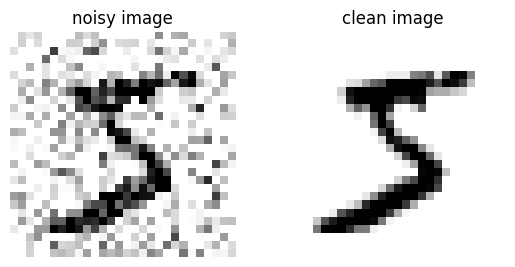

In [10]:
for sample_batch in combined_train_dataset.take(1):
    print(sample_batch[0].shape,sample_batch[1].shape)
    
plt.subplot(121)
plt.title("noisy image")
plt.imshow(sample_batch[0][0].numpy(),cmap="binary")
plt.axis("off")
plt.subplot(122)
plt.title("clean image")
plt.imshow(sample_batch[1][0].numpy(),cmap="binary")
plt.axis("off");    

In [11]:
encoder_input = Input(shape=(28,28,1))
x = Conv2D(filters=64,kernel_size=2,activation="relu",padding="same")(encoder_input)
x = MaxPooling2D(strides=2,padding="same")(x)
x = Conv2D(filters=32,kernel_size=2,activation="relu",padding="same")(x)
x = MaxPooling2D(strides=2,padding="same")(x)
x = Conv2DTranspose(filters=32,kernel_size=2,activation="relu",padding="same")(x)
x = Reshape((14,14,8))(x)
x = Conv2DTranspose(filters=32,kernel_size=2,activation="relu",padding="same")(x)
x = Reshape((28,28,8))(x)
x = Conv2DTranspose(filters=64,kernel_size=2,activation="relu",padding="same")(x)
decoded_output = Conv2DTranspose(filters=1, kernel_size=2, activation="relu", padding="same")(x)

model = Model(encoder_input,decoded_output,name="auto_encoder")
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "auto_encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 64)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        8224      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 32)        

In [12]:
model.fit(combined_train_dataset, epochs=100,validation_data=combined_test_dataset,shuffle=True)

Epoch 1/100
469/469 [==============================] - 54s 113ms/step - loss: 0.0386 - val_loss: 0.0230
Epoch 2/100
469/469 [==============================] - 54s 115ms/step - loss: 0.0183 - val_loss: 0.0168
Epoch 3/100
469/469 [==============================] - 54s 115ms/step - loss: 0.0151 - val_loss: 0.0140
Epoch 4/100
469/469 [==============================] - 53s 114ms/step - loss: 0.0136 - val_loss: 0.0128
Epoch 5/100
469/469 [==============================] - 54s 114ms/step - loss: 0.0128 - val_loss: 0.0120
Epoch 6/100
469/469 [==============================] - 54s 115ms/step - loss: 0.0122 - val_loss: 0.0118
Epoch 7/100
469/469 [==============================] - 50s 108ms/step - loss: 0.0117 - val_loss: 0.0111
Epoch 8/100
469/469 [==============================] - 53s 113ms/step - loss: 0.0113 - val_loss: 0.0121
Epoch 9/100
469/469 [==============================] - 53s 114ms/step - loss: 0.0111 - val_loss: 0.0110
Epoch 10/100
469/469 [==============================] - 53s 114m

1/1 [==============================] - 0s 129ms/step


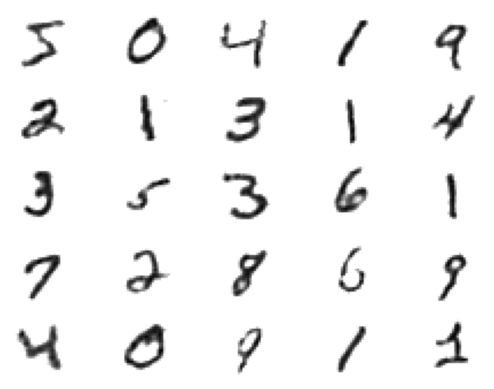

In [13]:
samp_preds = model.predict(sample_batch[0].numpy()[:25])

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(samp_preds[i],cmap="binary")
    plt.axis("off");

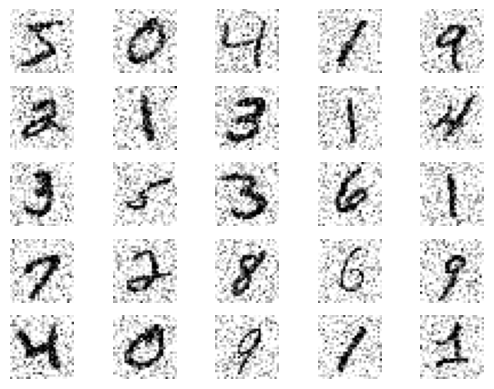

In [14]:
samp_acts = sample_batch[0].numpy()[:25]

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(samp_acts[i],cmap="binary")
    plt.axis("off");

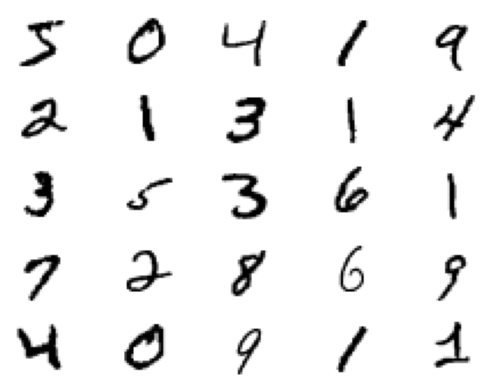

In [15]:
samp_acts = sample_batch[1].numpy()[:25]

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(samp_acts[i],cmap="binary")
    plt.axis("off");

In [16]:
model.save("auto_encoder")

INFO:tensorflow:Assets written to: auto_encoder\assets


INFO:tensorflow:Assets written to: auto_encoder\assets
